# Imports

In [76]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import os
from collections import Counter
from sklearn.manifold import TSNE
import seaborn as sns
import pandas as pd

# Load vqvae token data from files

In [77]:
# Get list of token files in token dir
token_dir_path = '/Users/jonojace/GLE_samples/vqvae_group.43.upconv/vqvae_tokens'
files = os.listdir(token_dir_path)

# TODO Filter token files to get those wanted for analysis (certain speakers, certain number from each speaker)

# Create data structure to hold all token data and metadata
data = {}
atom2group = {} # to keep track of what group an atom belongs to
match, mismatch = 0, 0
for file in files:
    #get data from file
    with open(f'{token_dir_path}/{file}') as f:
        groups_and_atoms = f.read().split('\n') # on each line of file is <group_id>_<atom_id>
    groups, atoms = [], []
    for line in groups_and_atoms:
        group, atom = line.split('_')
        if int(atom) in atom2group:
            # check that atoms are consistently mapped to groups
#             assert atom2group[int(atom)] == int(group), f"atom2group[int(atom)]={atom2group[int(atom)]}, int(group)={int(group)}"
            
            # TODO above line shows they are NOT consistently mapped, investigate this!
            if atom2group[int(atom)] == int(group):
                match += 1
            else:
                mismatch += 1
        else:
            atom2group[int(atom)] = int(group)
        groups.append(int(group))
        atoms.append(int(atom))
    #create entry for this file
    utt_id = os.path.basename(file)
    data[utt_id] = {'groups': groups, 'atoms':atoms}
    
print(f"Proportion of mismatch is {mismatch / (match + mismatch)}")
    
assert len(data) == len(files)

print(f"Finished processing {len(data)} vqvae token files")

Proportion of mismatch is 0.7144465375891977
Finished processing 11653 vqvae token files


# Plots

### Vqvae codebook plots

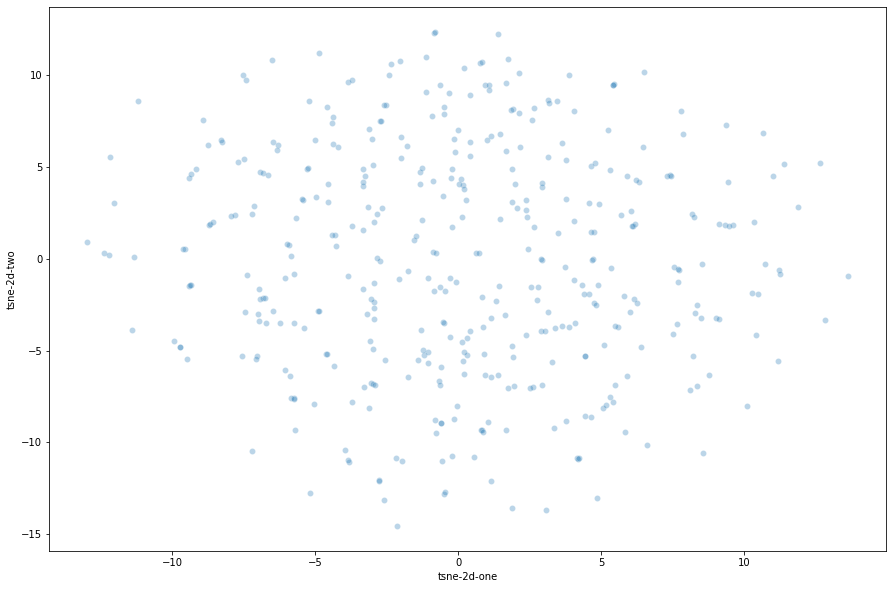

In [78]:
# load embeddings matrix from disk
embeddings0 = torch.load('/Users/jonojace/GLE_samples/vqvae_group.43.upconv/embeddings/vqvae_codebook.pt', map_location='cpu')
embeddings0 = embeddings0.squeeze().numpy()
N_atoms = embeddings0.shape[0]

# create pandas dataframe from numpy array
d = {
    'atom': range(N_atoms),
    'embedding':[embeddings0[i] for i in range(N_atoms)]
}
df = pd.DataFrame(data=d)
df.loc[:,"embedding"]
len(atom2group)
# [atom2group[atom] for atom in range(N_atoms)]

# fit T-SNE
tsne = TSNE(n_components=2, verbose=False, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(embeddings0)

# plot T-SNE
df['tsne-2d-one'] = tsne_results[:,0]
df['tsne-2d-two'] = tsne_results[:,1]
plt.figure(figsize=(15,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
#     hue="group",
    palette=sns.color_palette("hls", 410),
    data=df,
    legend="full",
    alpha=0.3
)
plt.show()


# get groups

# colour atoms from same group as same color

# also plot average of each group of atoms

### Token frequency histograms

In [79]:
# count frequencies of atoms and groups
groups_c, atoms_c = Counter(), Counter()
for utt_id in data:
    groups_c.update(data[utt_id]['groups'])
    atoms_c.update(data[utt_id]['atoms'])
    
print("Most common groups")
for group, count in groups_c.most_common(5):
    print(f'\tGroup {group} - {count}')
    
print("\nMost common atoms and their groups")
for atom, count in atoms_c.most_common(5):
    print(f'\tGroup {atom2group[atom]}, Atom {atom} - {count}')

Most common groups
	Group 12 - 1707617
	Group 34 - 566351
	Group 4 - 420587
	Group 26 - 414673
	Group 11 - 359594

Most common atoms and their groups
	Group 12, Atom 122 - 1031827
	Group 12, Atom 127 - 114837
	Group 25, Atom 123 - 106571
	Group 4, Atom 125 - 87317
	Group 34, Atom 213 - 81527


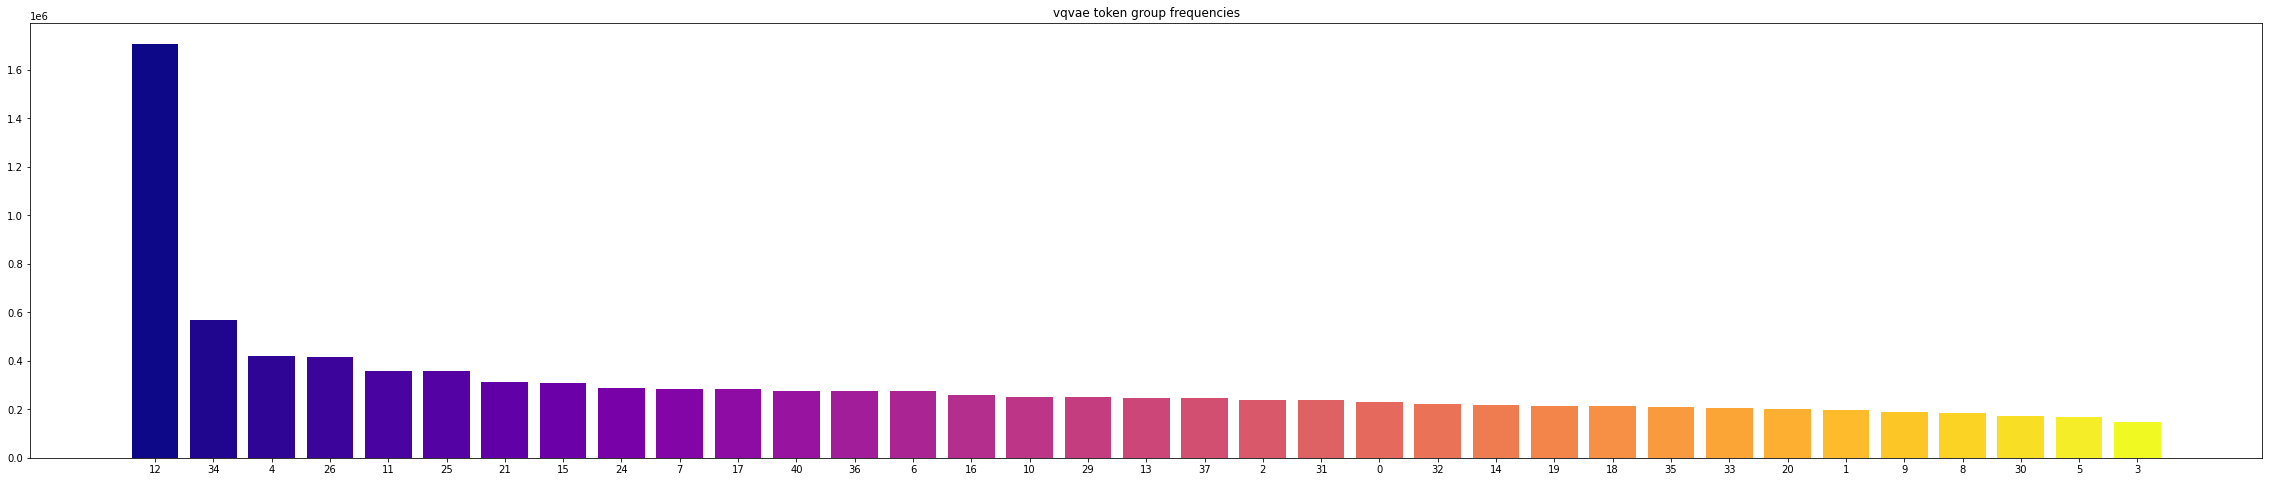

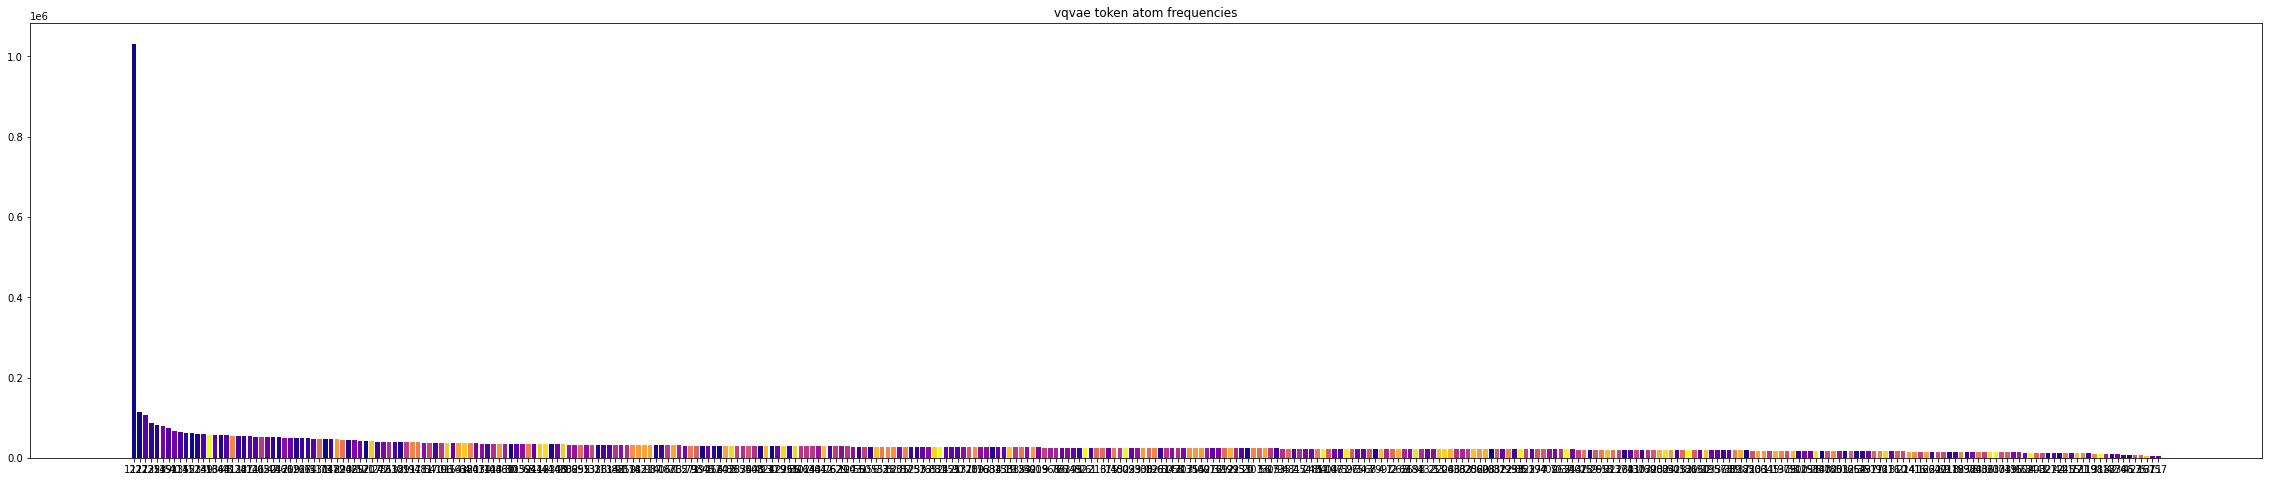

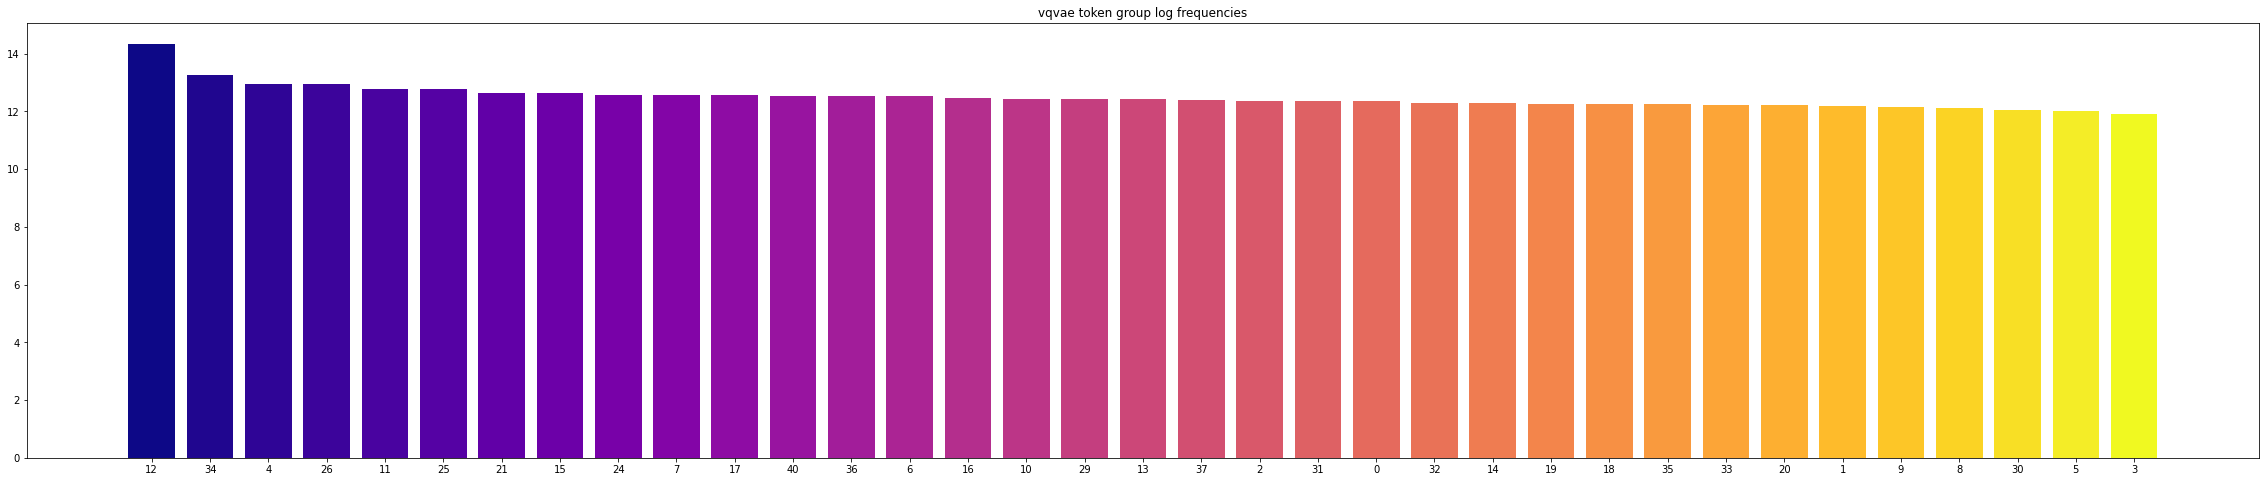

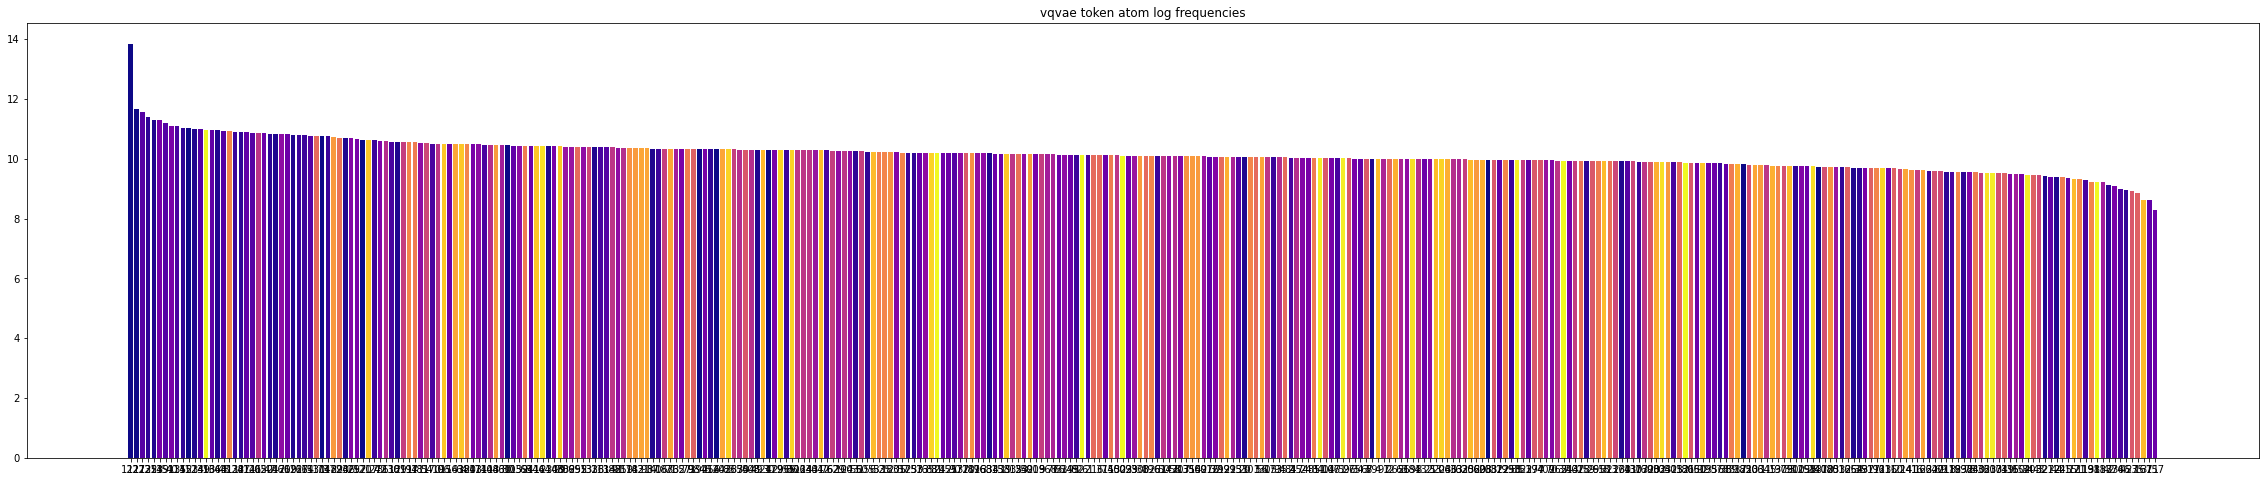

In [80]:
plt.rcParams['figure.figsize'] = [40, 8]

# Get equally spaced colors to assign to each group
total_num_groups = len(groups_c)
# cmap = plt.get_cmap('viridis')
cmap = plt.get_cmap('plasma')
# cmap = plt.get_cmap('rainbow')
# cmap = plt.get_cmap('gist_rainbow')
# cmap = plt.get_cmap('gist_ncar')
# print('Default number of colors in the lookup table:', len(cmap.colors)) # default: 256 colors
# print('First color:', cmap.colors[0])
# print('Last color:', cmap.colors[-1])
colors = cmap(np.linspace(0, 1, total_num_groups)).tolist() # get some equally spaced colors

# create mapping from group number to its color, colors are ordered by group freq
group2color = {}
for color, group in zip(colors, [group for group, count in groups_c.most_common()]):
    group2color[group] = color

def sorted_histogram(counter, token_type, title=None, morph_y_fn=None):
    N = len(counter)
    x = np.arange(N)
    x_labels = [str(key) for key, count in counter.most_common()]
    y = [count for key, count in counter.most_common()]
    
    # get color map 
    if token_type == 'groups':
         color_map = [group2color[int(group)] for group in x_labels]
    elif token_type == 'atoms':
         color_map = [group2color[atom2group[int(atom)]] for atom in x_labels]
    else:
         raise ValueError()
            
    # TODO add legend for color to group mapping
    
    if morph_y_fn:
        y = morph_y_fn(y)
        
    if title:
        plt.title(title)    
    
    plt.bar(x, y, color=color_map)
    plt.xticks(x, x_labels)
    plt.show()

sorted_histogram(groups_c, 'groups', title='vqvae token group frequencies')
sorted_histogram(atoms_c, 'atoms', title='vqvae token atom frequencies') # TODO single big bar 

sorted_histogram(groups_c, 'groups', title='vqvae token group log frequencies', morph_y_fn=np.log)
sorted_histogram(atoms_c, 'atoms', title='vqvae token atom log frequencies', morph_y_fn=np.log) 

# TODO plot atoms grouped with those atoms of same group, ranked by atom frequency, then finally ranked by group frequency
# e.g. group 12's 10 atoms ranked by atom frequency, then group 4's 10 atoms ranked by atom frequency, etc.... 

### Token id over time


Plots of groups over time SCATTER


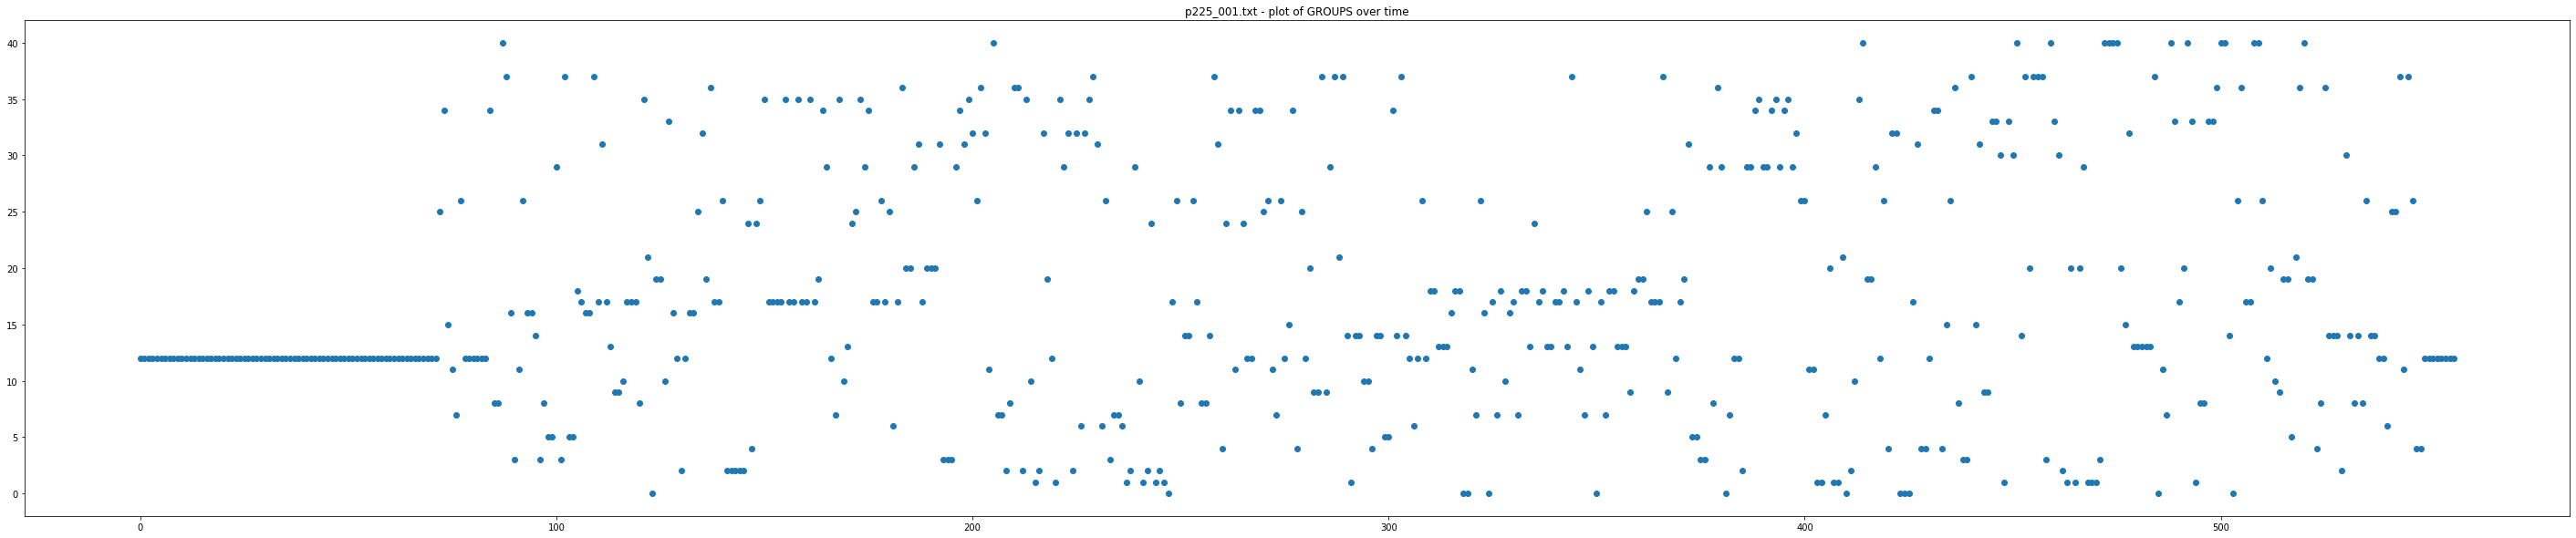

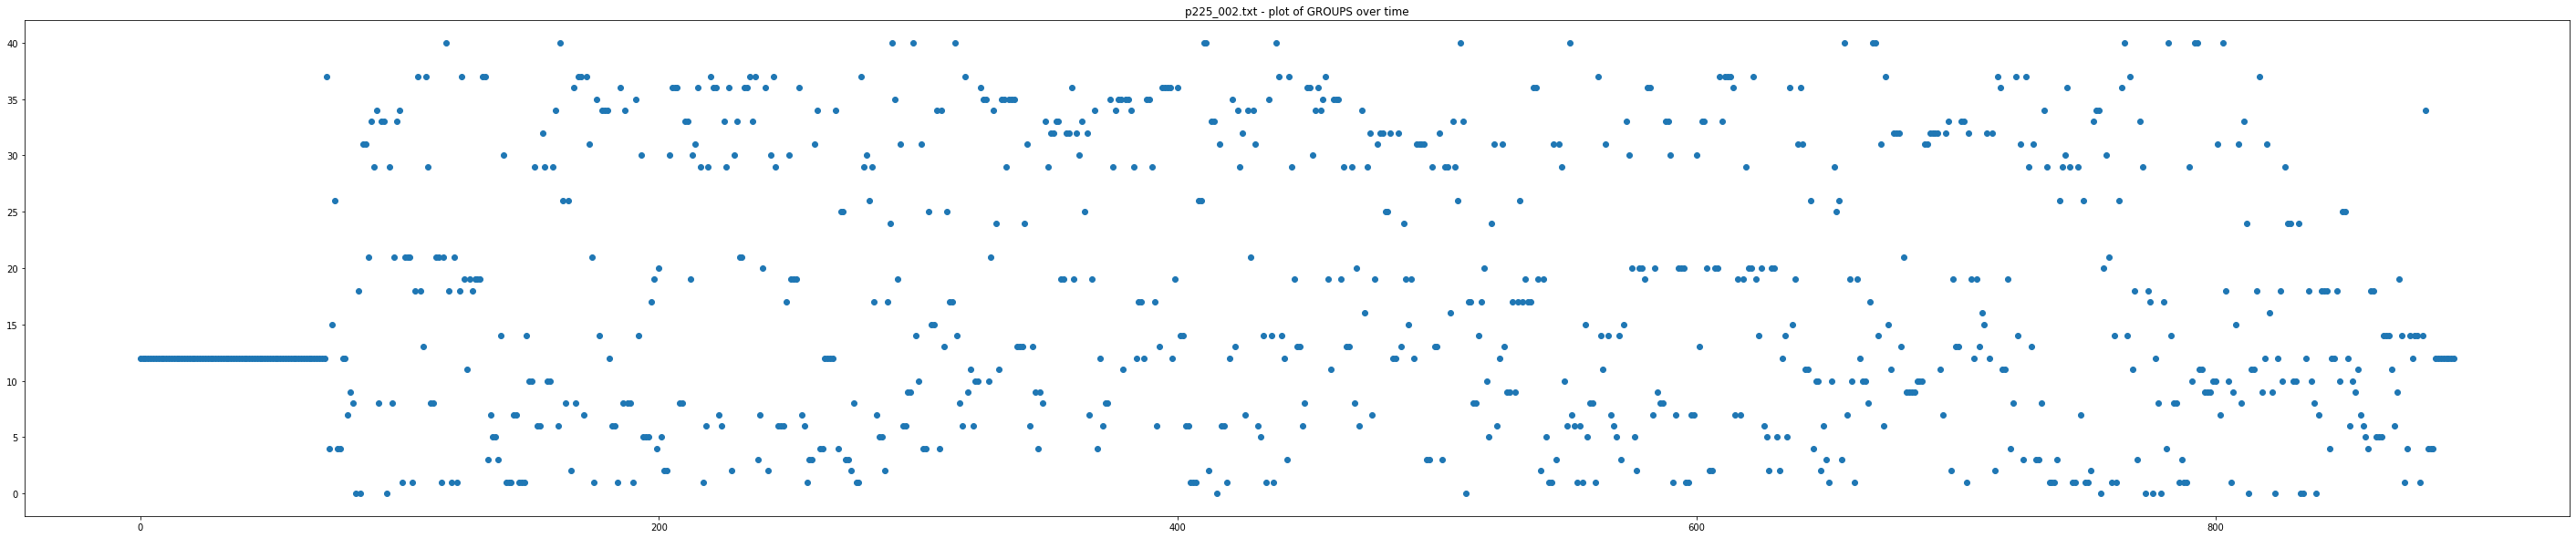

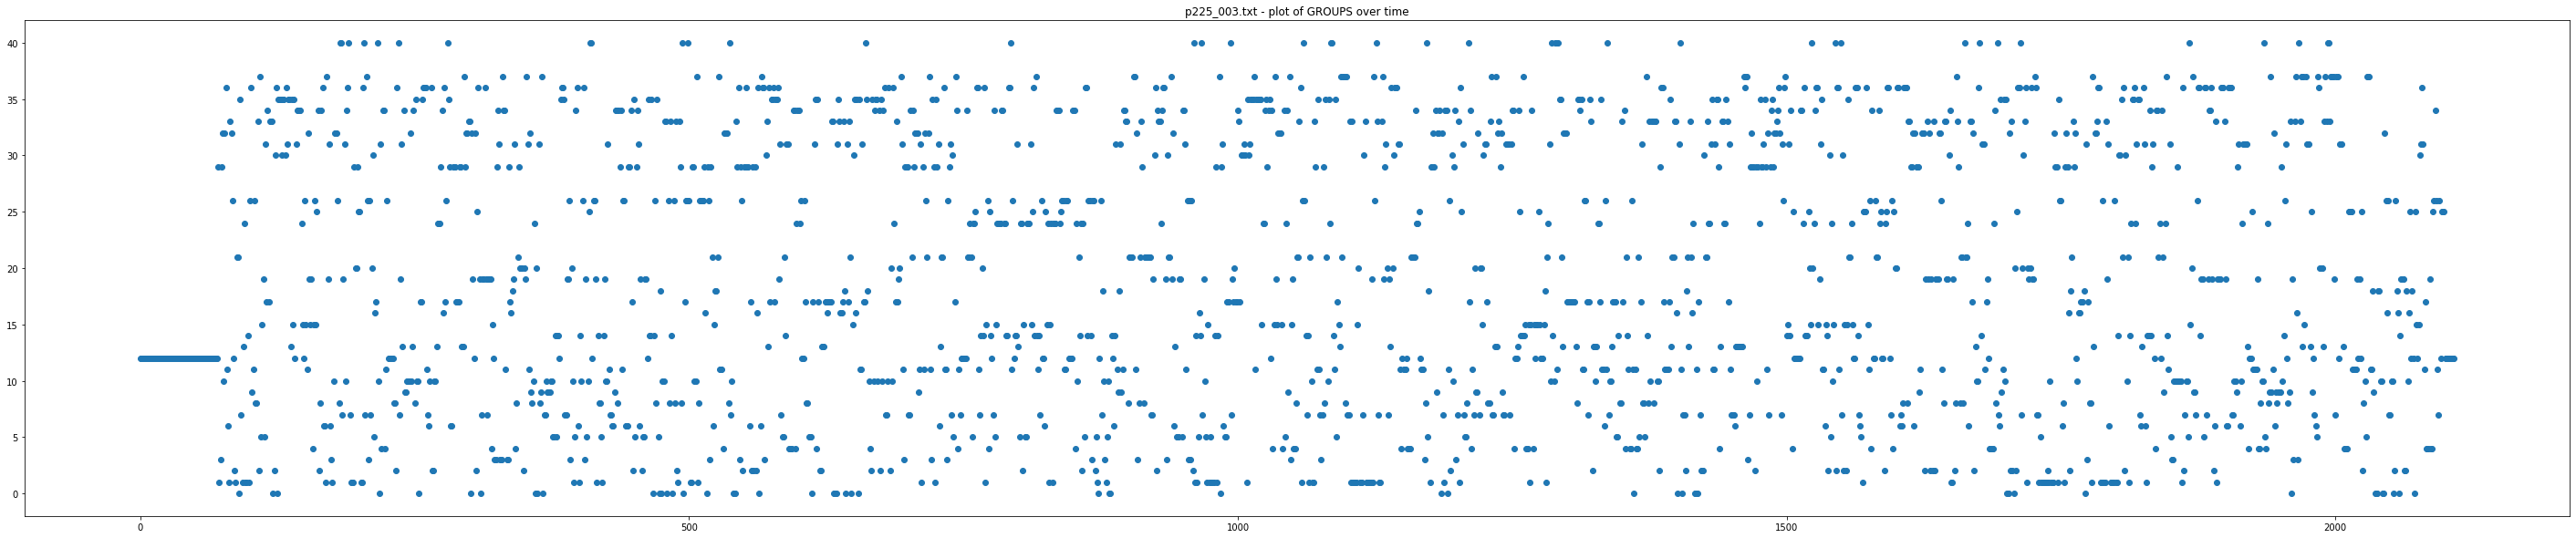


Plots of atoms over time SCATTER


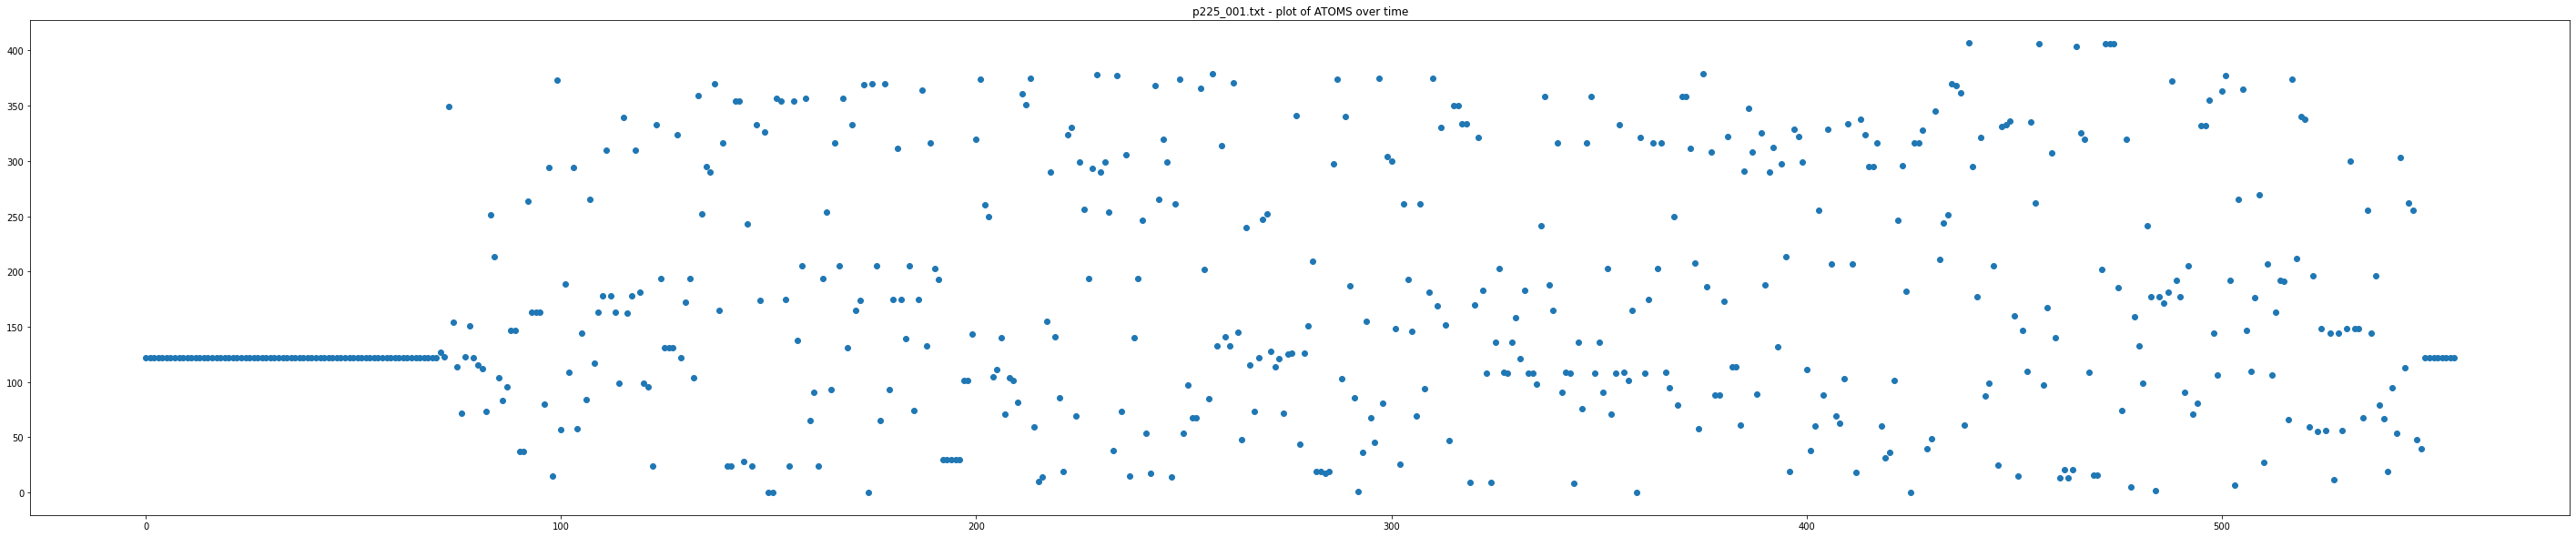

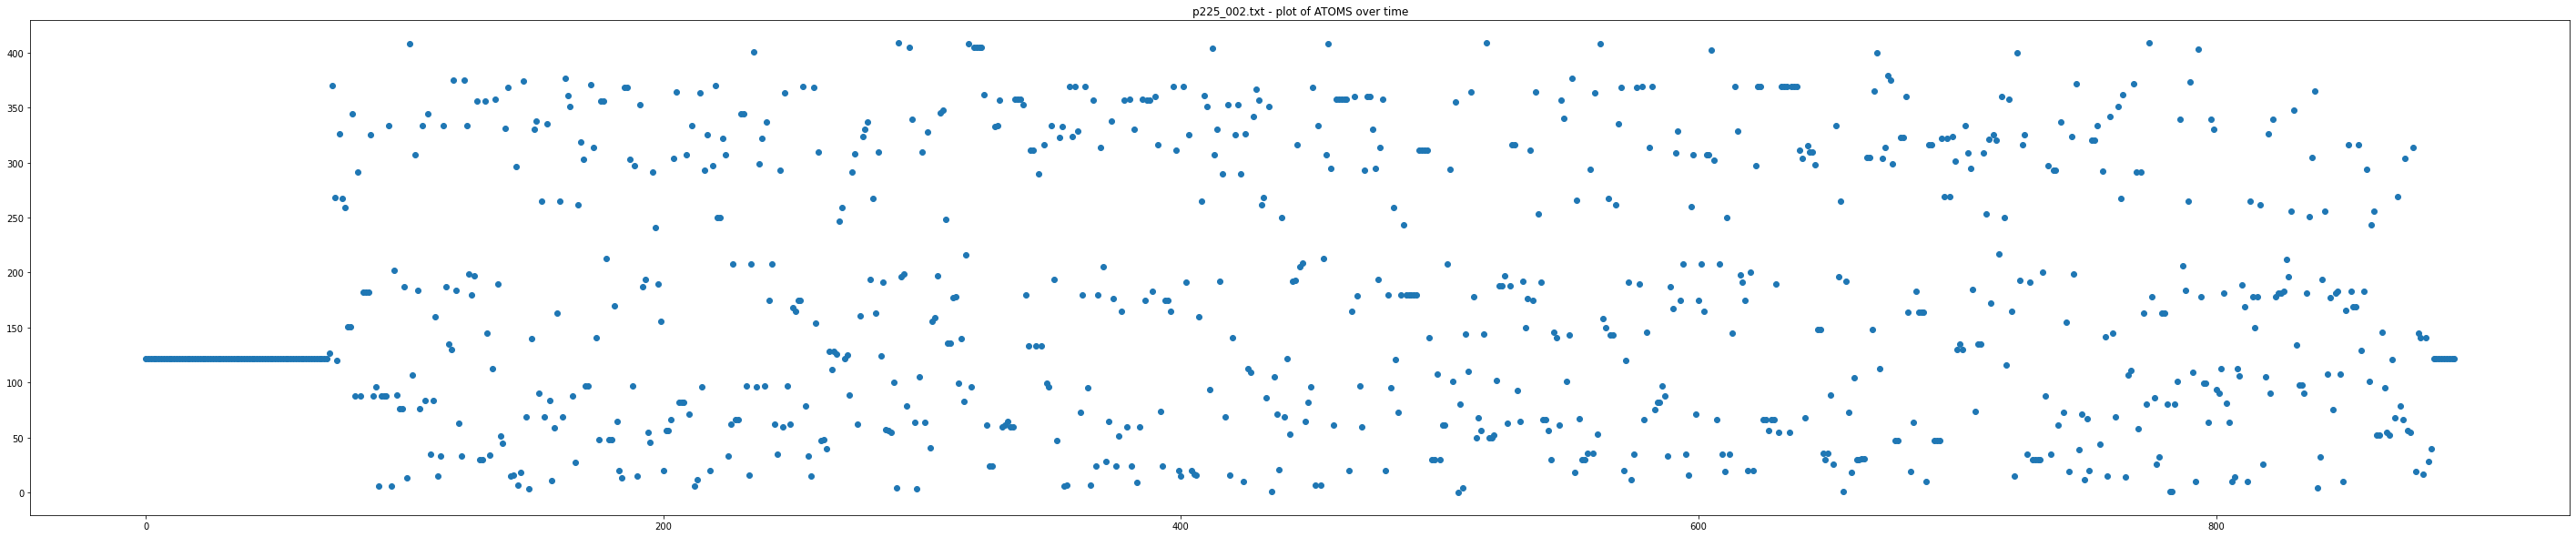

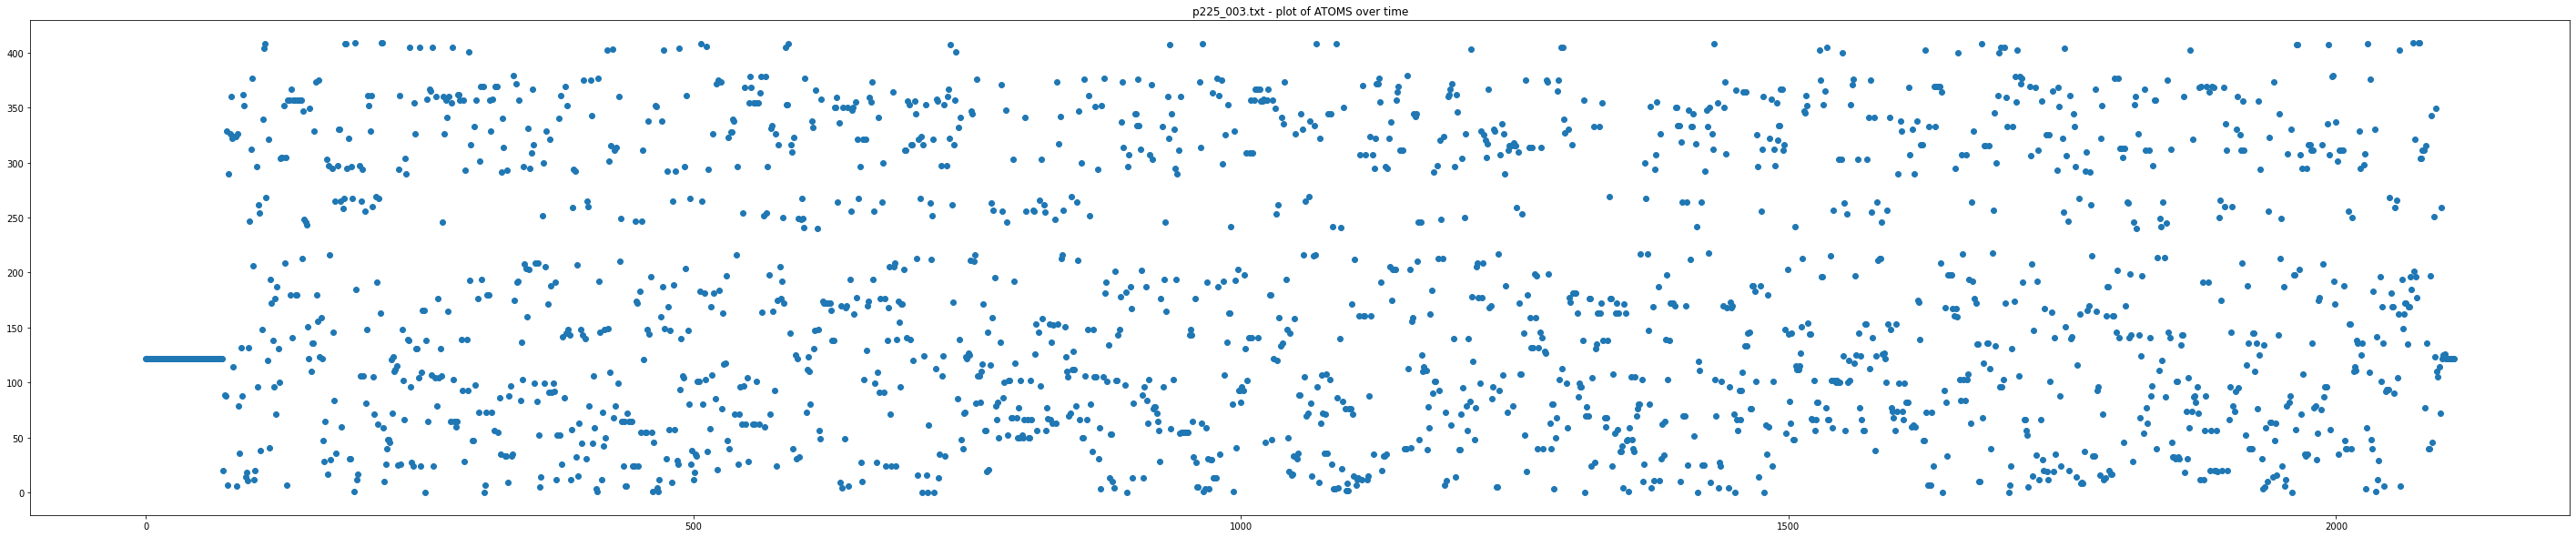


Plots of groups over time LINE


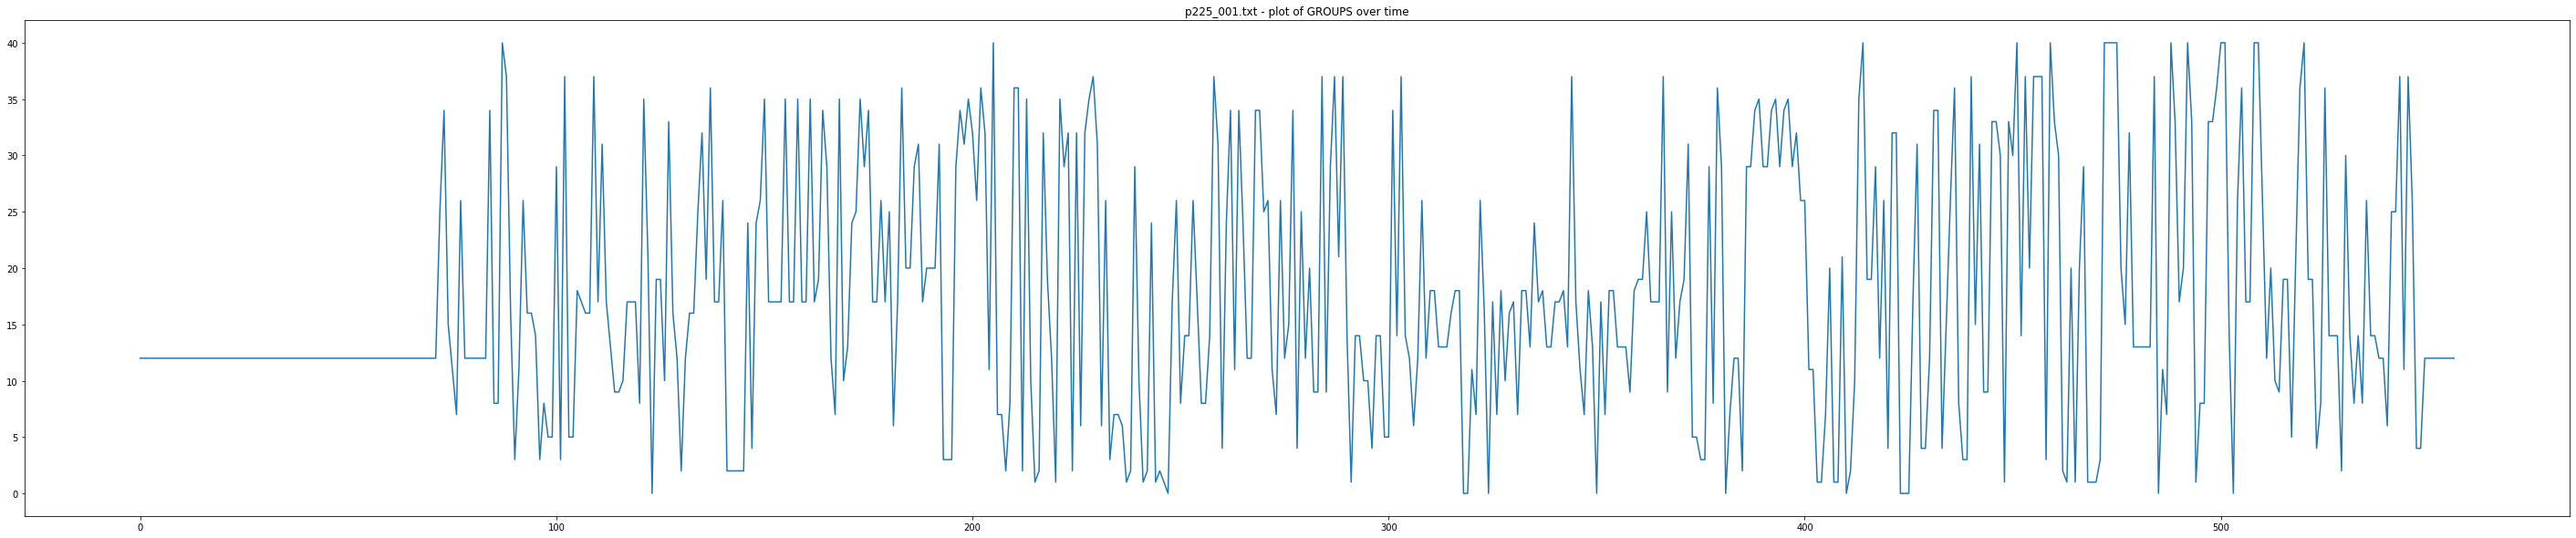

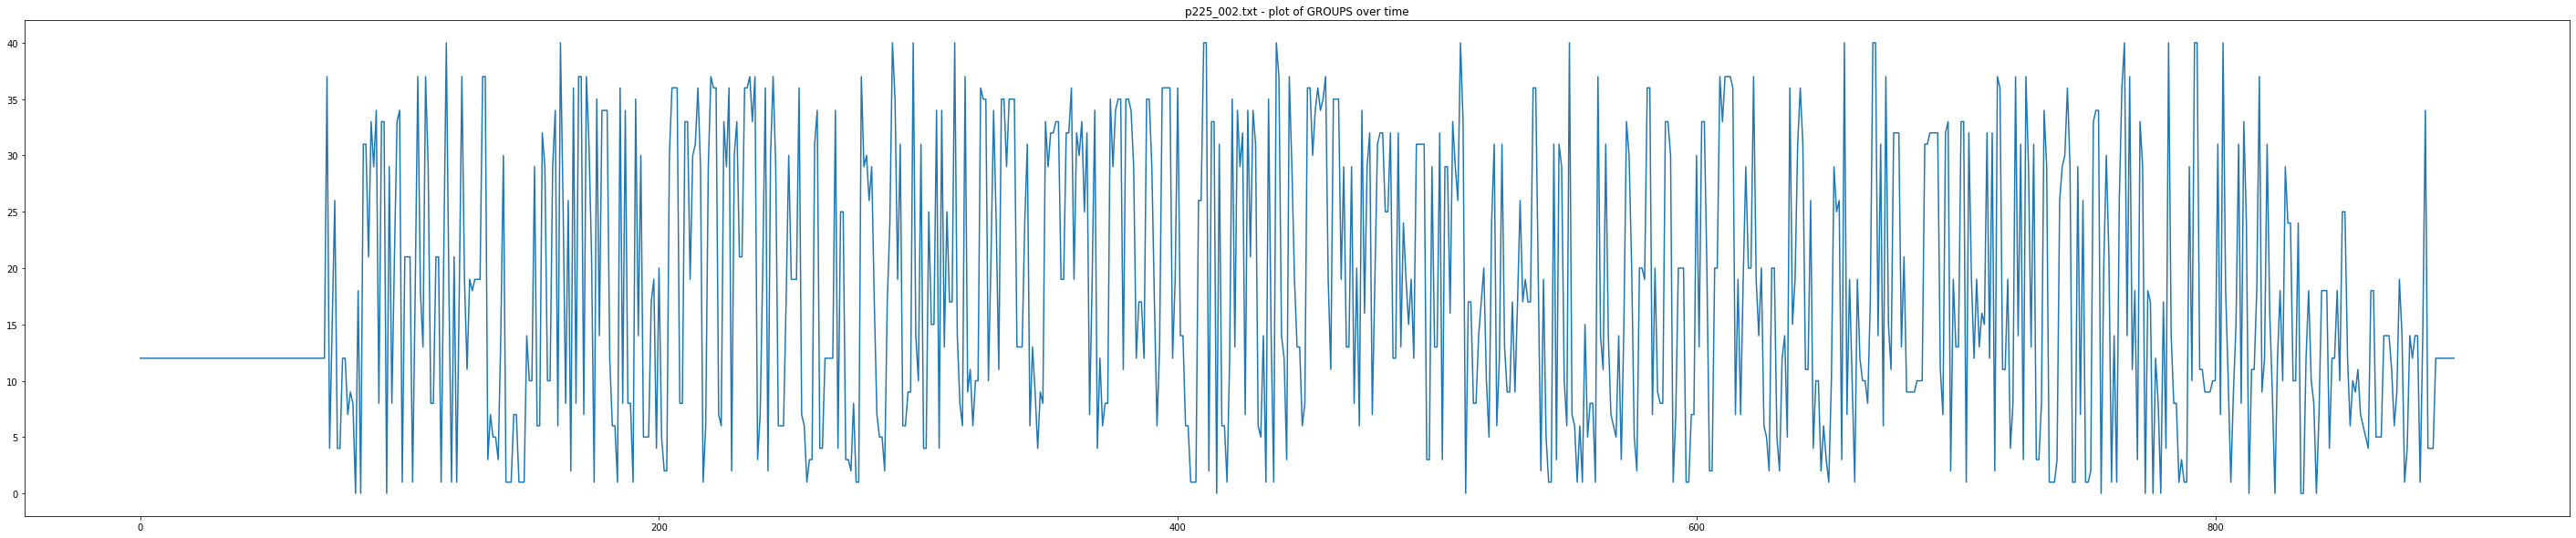

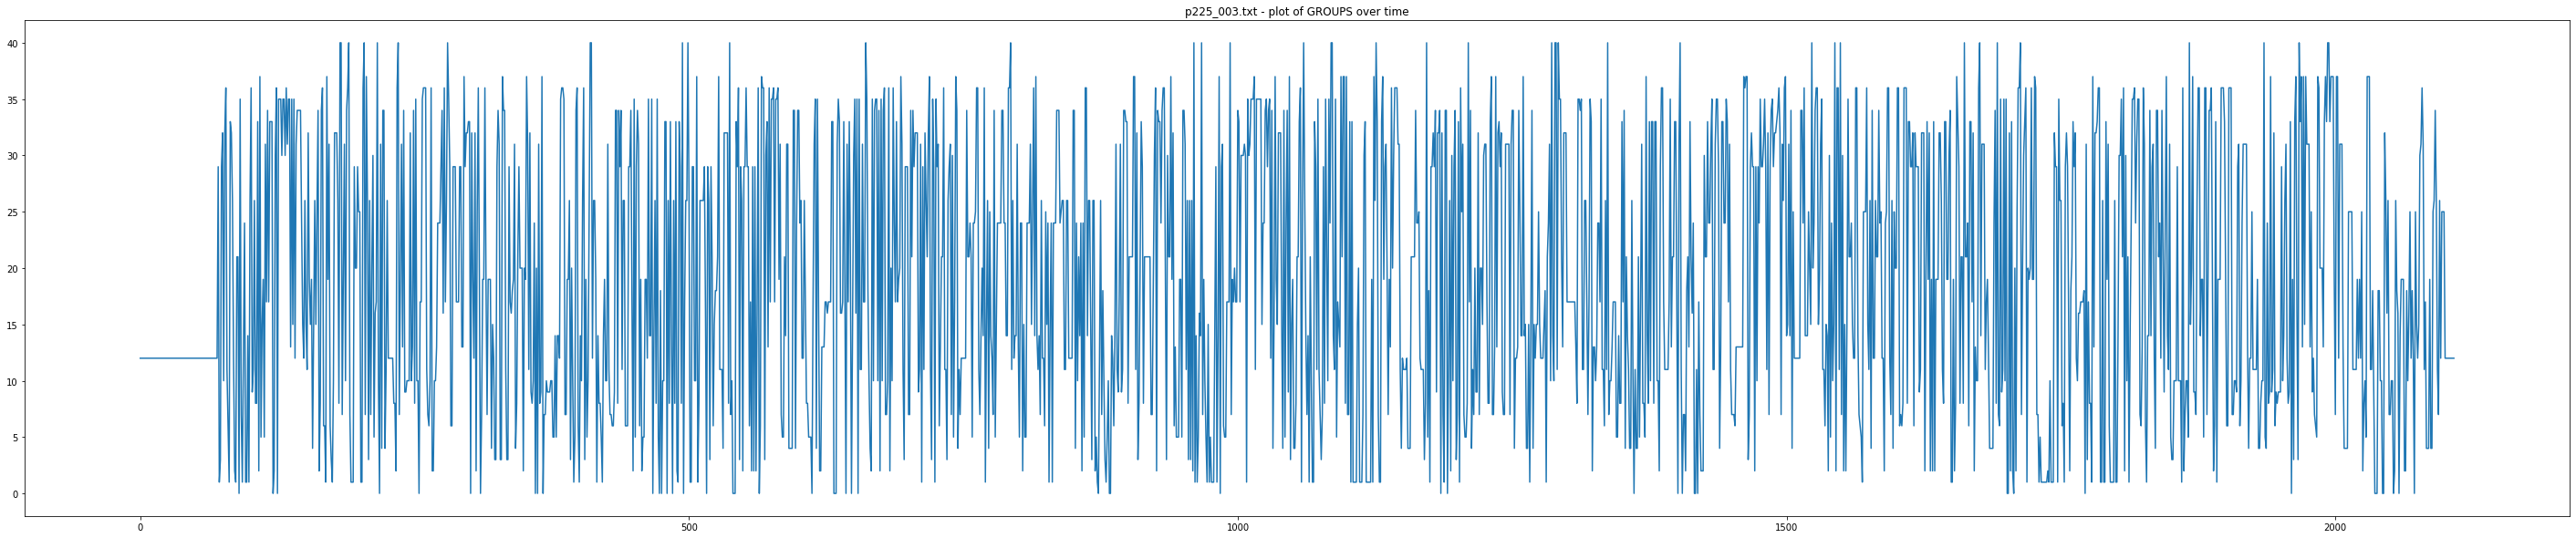


Plots of atoms over time LINE


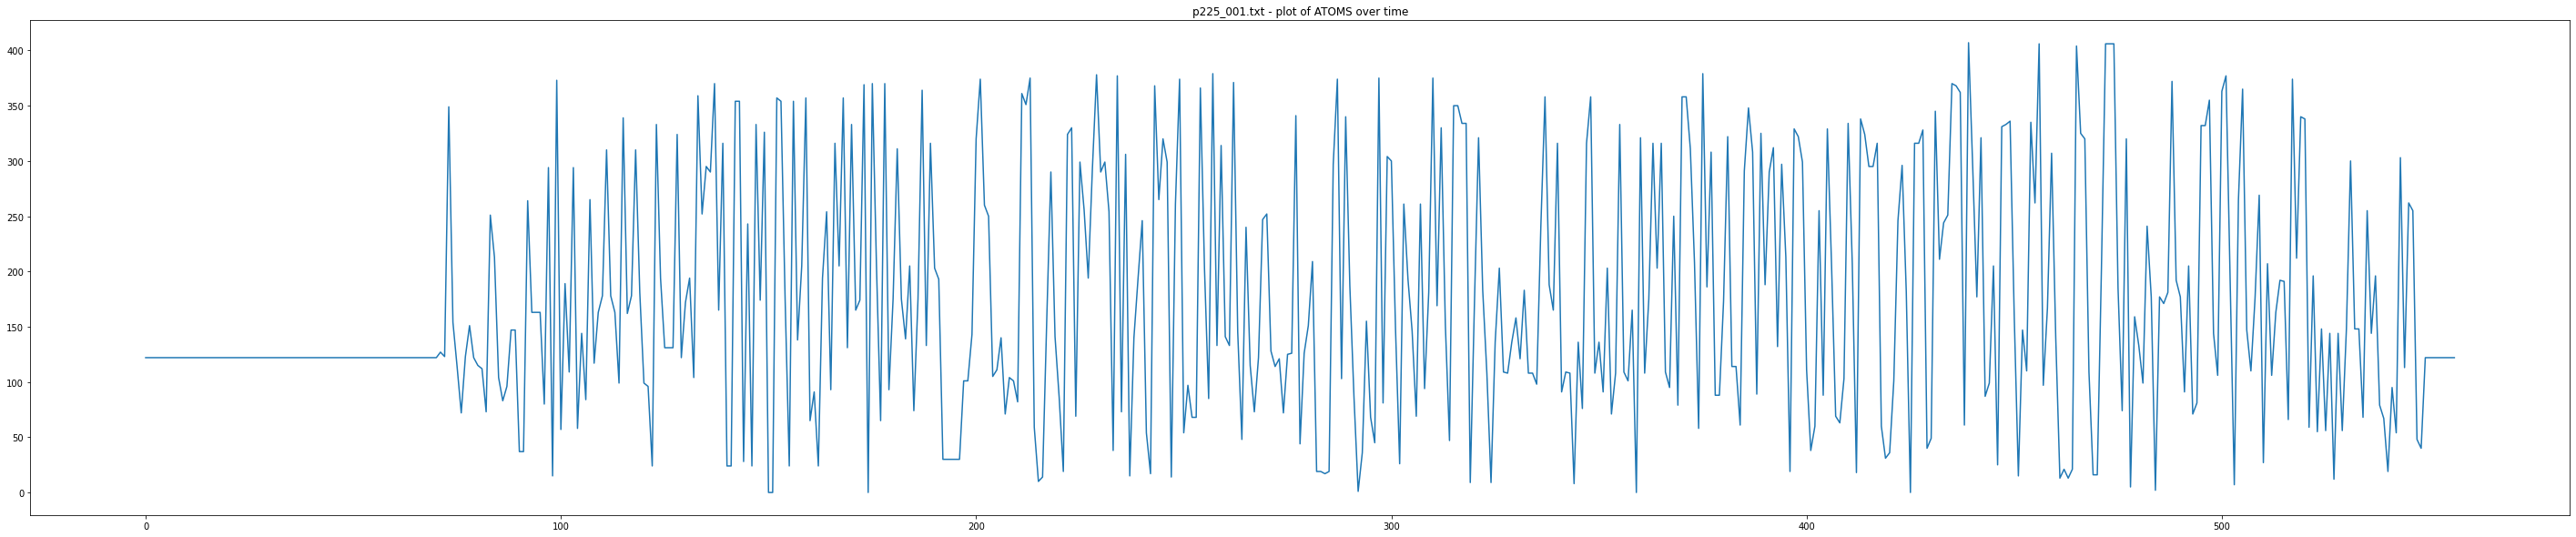

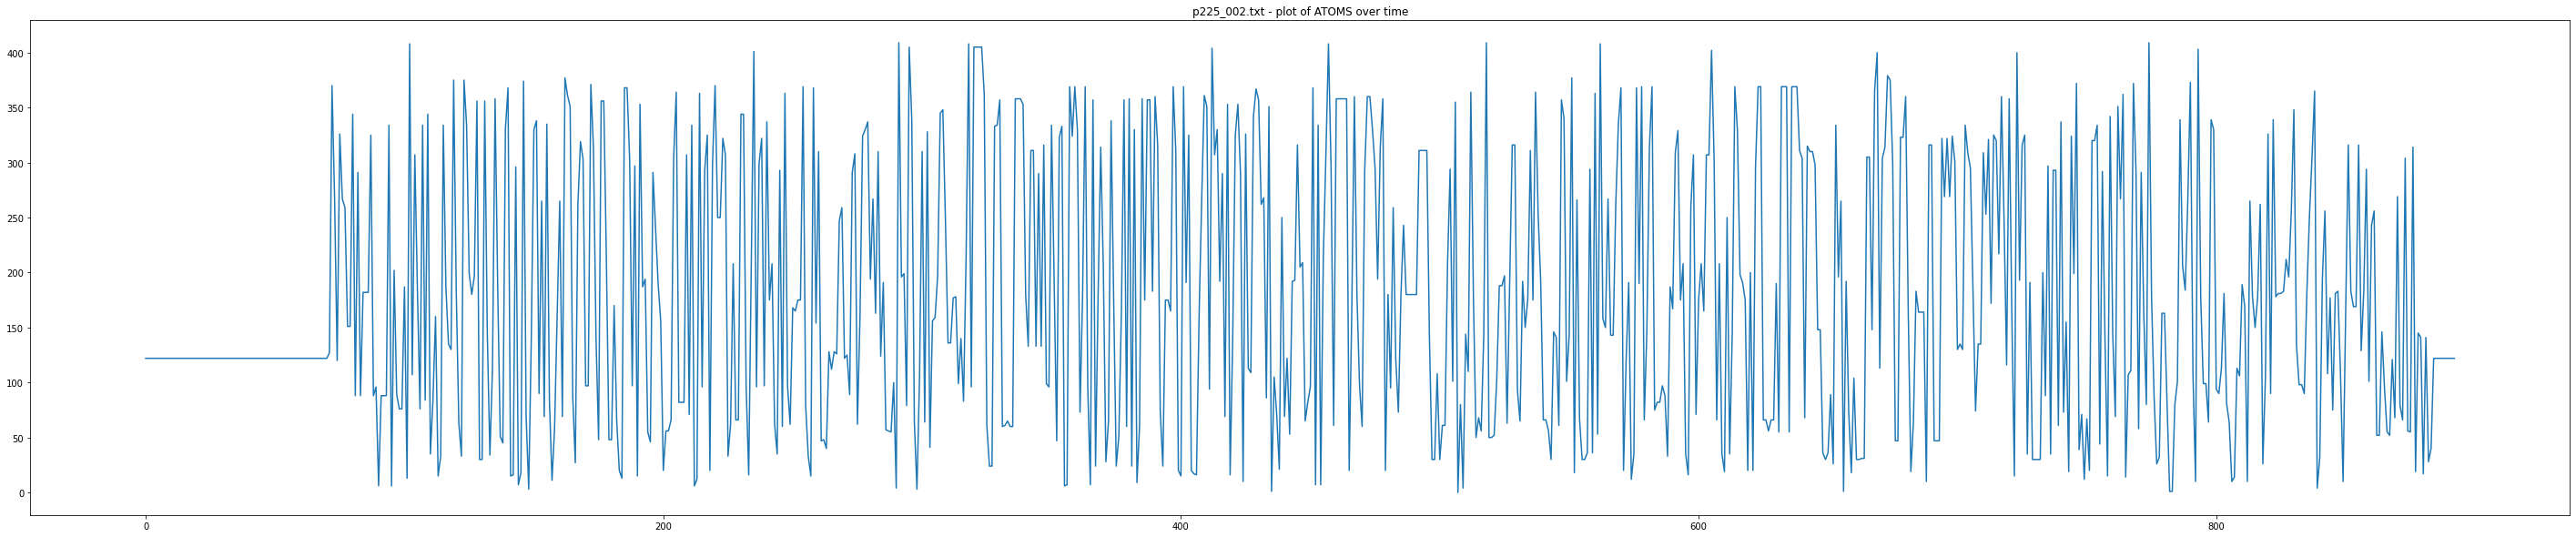

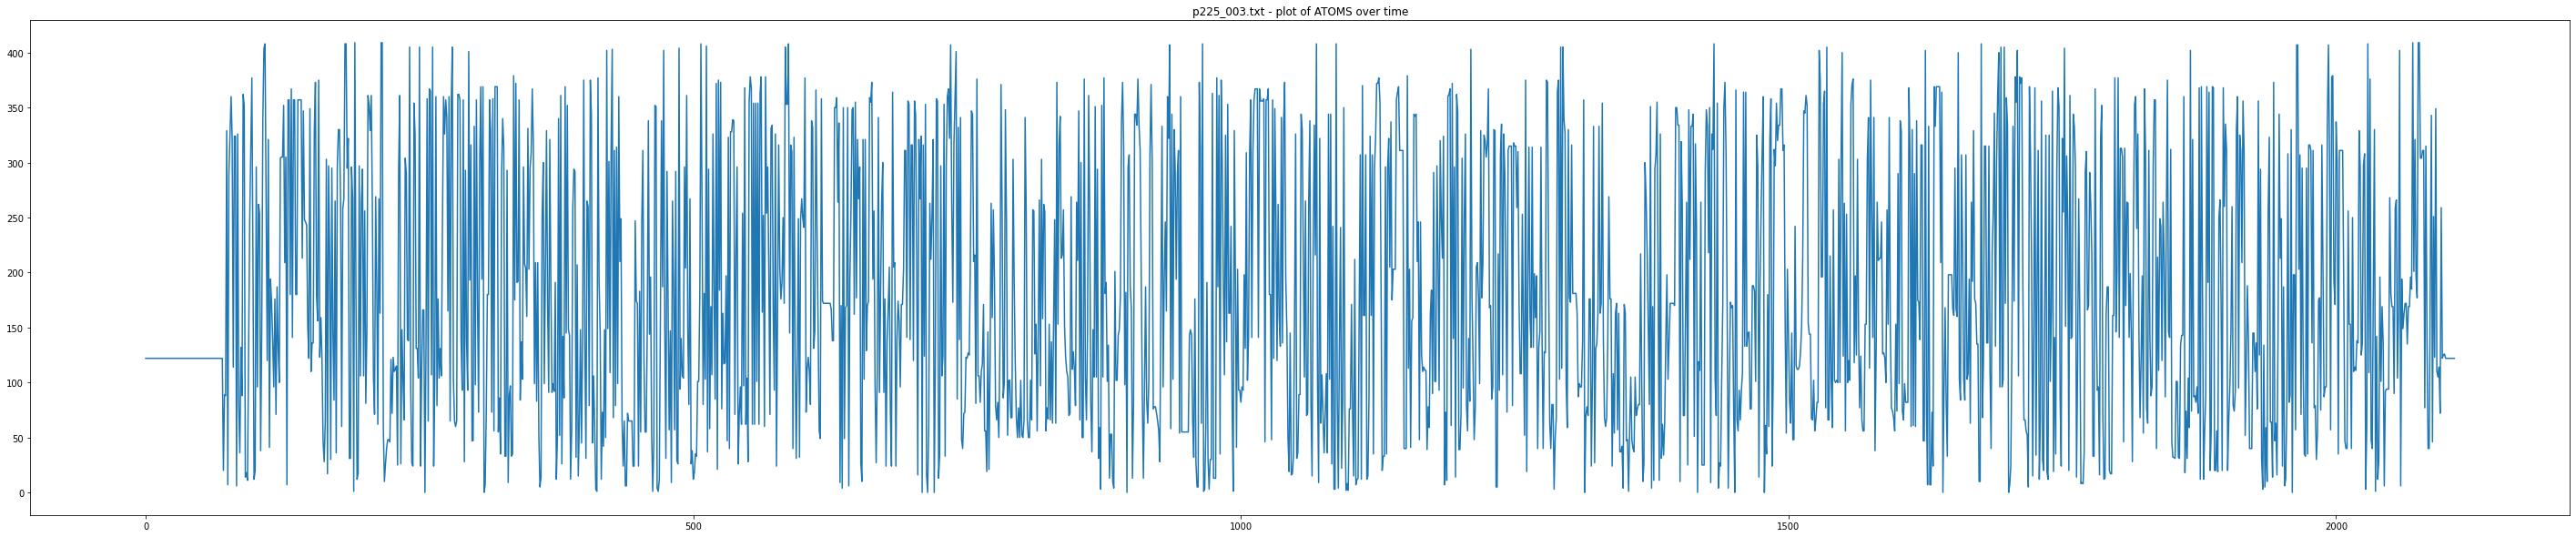

In [84]:
plt.rcParams['figure.figsize'] = [50, 10]

num_to_plot = 3

def plot_tokens_over_time(file, data_to_plot, plot_type='scatter'):
    y = data[file][data_to_plot]
    x = np.arange(len(y))
    plt.title(f"{file} - plot of {data_to_plot.upper()} over time")
    if plot_type == 'scatter':
        plt.scatter(x, y)
    elif plot_type == 'line':
        plt.plot(x, y) # this potentially shows that tokens fluctuate within a phone, so perhaps decoder uses combinations of tokens to to transmit more information
    else:
        raise ValueError
    plt.show()
    
sorted_files = sorted(data.keys())

#scatter plots
data_to_plot = 'groups'
print(f"\nPlots of {data_to_plot} over time SCATTER")
for file in sorted_files[:num_to_plot]:
    plot_tokens_over_time(file, data_to_plot, plot_type='scatter')
    
data_to_plot = 'atoms'
print(f"\nPlots of {data_to_plot} over time SCATTER")
for file in sorted_files[:num_to_plot]:
    plot_tokens_over_time(file, data_to_plot, plot_type='scatter')
    
#line plots
data_to_plot = 'groups'
print(f"\nPlots of {data_to_plot} over time LINE")
for file in sorted_files[:num_to_plot]:
    plot_tokens_over_time(file, data_to_plot, plot_type='line')
    
data_to_plot = 'atoms'
print(f"\nPlots of {data_to_plot} over time LINE")
for file in sorted_files[:num_to_plot]:
    plot_tokens_over_time(file, data_to_plot, plot_type='line')
    
# TODO color code the different groups